# 365 Data Science Customer Segmentation in Marketing

## Table of Contents

- [1. Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)
    - [1.1. Data Importing & Inspection](#1.1.-Data-Importing-&-Inspection)
    - [1.2. Data Visualization & Correlation Analysis](#1.2.-Data-Visualization-&-Correlation-Analysis)
- [2. Model Implementation](#2.-Model-Implementation)
    - [2.1. Feature Engineering](#2.1.-Feature-Engineering)
    - [2.2. Hierarchical Clustering](#2.2.-Hierarchical-Clustering)
    - [2.3. K-Means Clustering](#2.3.-K-Means-Clustering)
- [3. K-Means Model Assessment](#3.-K-Means-Model-Assessment)

## 1. Exploratory Data Analysis

### 1.1. Data Importing & Inspection

In [1]:
# Import libraries for data manipulation, visualization, and clustering
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load and preview customer data from a CSV file
customers = pd.read_csv('Customer_Data.csv', sep=',', index_col=False)
customers.head()

,minutes_watched,CLV,region,channel
0,3197.0,205.42,2,4
1,63.0,149.99,0,1
2,605.0,119.00,2,2
3,20.0,240.00,2,4
4,245.0,184.36,1,4


In [2]:
# Generate summary statistics for the customers dataset
customers.describe()

,minutes_watched,CLV,region,channel
count,3725.000000,3834.000000,3834.000000,3834.000000
mean,1972.094497,118.383920,1.167188,3.870370
std,7401.693028,70.471274,0.923055,2.191972
min,0.000000,0.000000,0.000000,1.000000
25%,159.000000,62.580000,0.000000,2.000000
50%,512.000000,119.000000,2.000000,3.000000
75%,1521.000000,149.990000,2.000000,6.000000
max,288508.000000,626.400000,2.000000,8.000000


In [3]:
# Display data types of all columns in the dataset
customers.dtypes

minutes_watched    float64
CLV                float64
region               int64
channel              int64
dtype: object

In [4]:
# Count the number of missing values in each column of the dataset
customers.isnull().sum()

minutes_watched    109
CLV                  0
region               0
channel              0
dtype: int64

In [5]:
# Replace missing values in the 'minutes_watched' column with 0
customers['minutes_watched'] = customers['minutes_watched'].fillna(0)

### 1.2. Data Visualization & Correlation Analysis

In [6]:
# Compute the correlation matrix for numerical columns
customers.corr()

,minutes_watched,CLV,region,channel
minutes_watched,1.000000,0.114153,0.040100,-0.003718
CLV,0.114153,1.000000,-0.273312,-0.026359
region,0.040100,-0.273312,1.000000,0.015098
channel,-0.003718,-0.026359,0.015098,1.000000


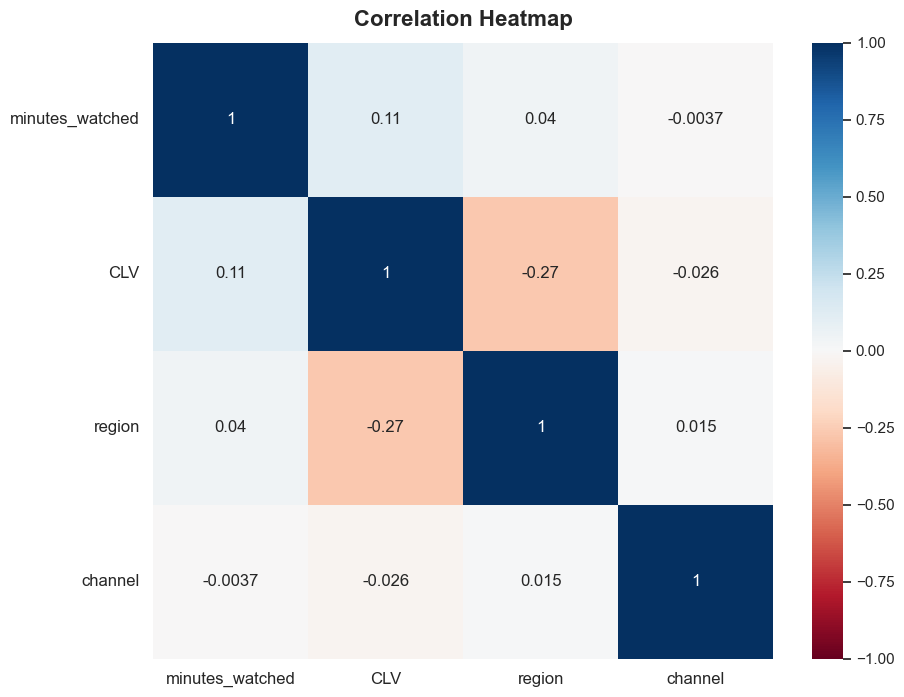

In [7]:
# Plot a heatmap to visualize correlations between numerical features
plt.figure(figsize=(10, 8))

heatmap = sns.heatmap(customers.corr(), cmap='RdBu', annot=True, vmin=-1, vmax=1)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=12)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=0, fontsize=12)

plt.title('Correlation Heatmap', fontweight='bold', fontsize=16, pad=12)
plt.show()

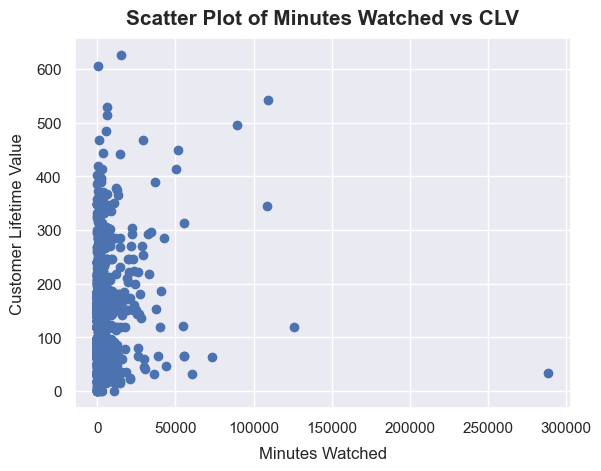

In [8]:
# Create a scatter plot to visualize the relationship between 'minutes_watched' and 'CLV'
plt.figure()
plt.scatter(customers.iloc[:, 0], customers.iloc[:, 1])

plt.title('Scatter Plot of Minutes Watched vs CLV', fontweight='bold', fontsize=15, pad=10)
plt.ylabel('Customer Lifetime Value', fontsize=12, labelpad=8)
plt.xlabel('Minutes Watched', fontsize=12, labelpad=8)

plt.show()

## 2. Model Implementation

### 2.1. Feature Engineering

In [9]:
# Convert categorical columns to dummy variables and rename columns for better readability
customers = pd.get_dummies(customers, columns=['region', 'channel'], drop_first=False)

customers = customers.rename(columns={'channel_1':'Google', 'channel_2':'Facebook', 'channel_3':'YouTube', 'channel_4':'LinkedIn',
                                      'channel_5':'X', 'channel_6':'Instagram', 'channel_7':'Friend', 'channel_8':'Other',
                                      'minutes_watched':'Minutes Watched', 'region_0':'English-Speaking Countries',
                                      'region_1':'Western Europe', 'region_2':'Other Countries'})
customers.head()

,Minutes Watched,CLV,English-Speaking Countries,Western Europe,Other Countries,Google,Facebook,YouTube,LinkedIn,X,Instagram,Friend,Other
0,3197.0,205.42,False,False,True,False,False,False,True,False,False,False,False
1,63.0,149.99,True,False,False,True,False,False,False,False,False,False,False
2,605.0,119.00,False,False,True,False,True,False,False,False,False,False,False
3,20.0,240.00,False,False,True,False,False,False,True,False,False,False,False
4,245.0,184.36,False,True,False,False,False,False,True,False,False,False,False


In [10]:
# Scale customer data for clustering analysis and preview the first 3 rows
scaler = StandardScaler()
customers_scaled = scaler.fit_transform(customers)
customers_scaled[:3]

array([[ 0.17542513,  1.23521866, -0.74396546, -0.36969391,  0.95410372,
        -0.46058699, -0.29450754, -0.63187821,  2.21324683, -0.12393615,
        -0.28552281, -0.37740094, -0.2849882 ],
       [-0.25376647,  0.44855443,  1.34414843, -0.36969391, -1.04810408,
         2.17114254, -0.29450754, -0.63187821, -0.45182489, -0.12393615,
        -0.28552281, -0.37740094, -0.2849882 ],
       [-0.17954125,  0.00874342, -0.74396546, -0.36969391,  0.95410372,
        -0.46058699,  3.39549875, -0.63187821, -0.45182489, -0.12393615,
        -0.28552281, -0.37740094, -0.2849882 ]])

### 2.2. Hierarchical Clustering

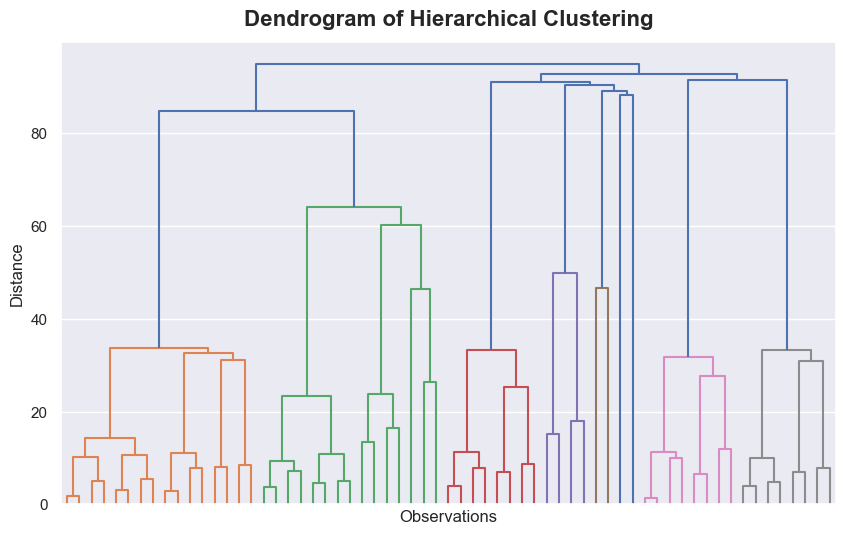

In [11]:
# Plot a dendrogram to visualize hierarchical clustering results
plt.figure(figsize=(10, 6))
dendrogram(linkage(customers_scaled, method='ward'), truncate_mode='level', show_leaf_counts=False, no_labels=True, p=5)

plt.title('Dendrogram of Hierarchical Clustering', fontweight='bold', fontsize=16, pad=12)
plt.xlabel('Observations', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.show()

### 2.3. K-Means Clustering

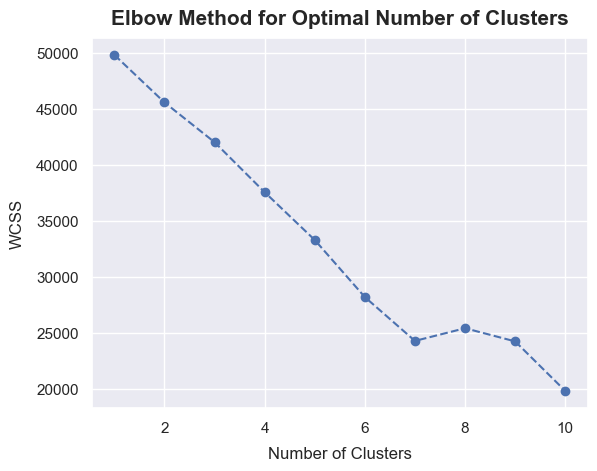

In [12]:
# Calculate the Within-Cluster Sum of Squares (WCSS) for different numbers of clusters in K-means
wcss = []

for i in range(1, 11):
    
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(customers_scaled)
    wcss.append(kmeans.inertia_)


# Plot the Elbow Method to determine the optimal number of clusters
plt.figure()
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')

plt.title('Elbow Method for Optimal Number of Clusters', fontweight='bold', fontsize=15, pad=10)
plt.xlabel('Number of Clusters', fontsize=12, labelpad=8)
plt.ylabel('WCSS', fontsize=12, labelpad=8)
plt.show()

## 3. K-Means Model Assessment

In [13]:
# Apply K-means clustering with 8 clusters and assign cluster labels to customers_kmean
kmeans = KMeans(n_clusters=8, init='k-means++', random_state=42)
kmeans.fit(customers_scaled)

customers_kmean = customers.copy()
customers_kmean['Cluster Number'] = kmeans.labels_


# Group customers by cluster, calculate cluster size and proportion, and summarize the data with mean values
customers_grouped = customers_kmean.groupby(['Cluster Number']).mean()
customers_grouped['Cluster Size'] = customers_kmean[['Cluster Number', 'Minutes Watched']].groupby(['Cluster Number']).count()
customers_grouped['Cluster Proportion'] = customers_grouped['Cluster Size'] / customers_grouped['Cluster Size'].sum()
customers_grouped.round(2)

,Minutes Watched,CLV,English-Speaking Countries,Western Europe,Other Countries,Google,Facebook,YouTube,LinkedIn,X,Instagram,Friend,Other,Cluster Size,Cluster Proportion
Cluster Number,,,,,,,,,,,,,,,
0,2767.64,108.26,0.29,0.10,0.61,0.0,1.0,0.00,0.0,0.00,0.0,0.0,0.0,306,0.08
1,1822.27,124.82,0.39,0.13,0.49,0.0,0.0,0.76,0.0,0.04,0.2,0.0,0.0,1441,0.38
2,2422.45,144.03,0.69,0.31,0.00,0.0,0.0,0.00,0.0,0.00,0.0,1.0,0.0,177,0.05
3,1165.42,124.42,1.00,0.00,0.00,0.0,0.0,0.00,1.0,0.00,0.0,0.0,0.0,189,0.05
4,1810.36,121.15,0.39,0.12,0.49,1.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,671,0.18
5,1761.41,95.79,0.00,0.00,1.00,0.0,0.0,0.00,0.0,0.00,0.0,1.0,0.0,301,0.08
6,1763.19,100.38,0.00,0.15,0.85,0.0,0.0,0.00,1.0,0.00,0.0,0.0,0.0,461,0.12
7,2314.08,123.19,0.51,0.14,0.35,0.0,0.0,0.00,0.0,0.00,0.0,0.0,1.0,288,0.08


In [14]:
# Display correlation of CLV with all regions and channels
customers_grouped.corr().iloc[2:-2, 1].round(4)

English-Speaking Countries    0.7912
Western Europe                0.6179
Other Countries              -0.9075
Google                        0.0881
Facebook                     -0.2462
YouTube                       0.1832
LinkedIn                     -0.2121
X                             0.1832
Instagram                     0.1832
Friend                        0.0853
Other                         0.1409
Name: CLV, dtype: float64

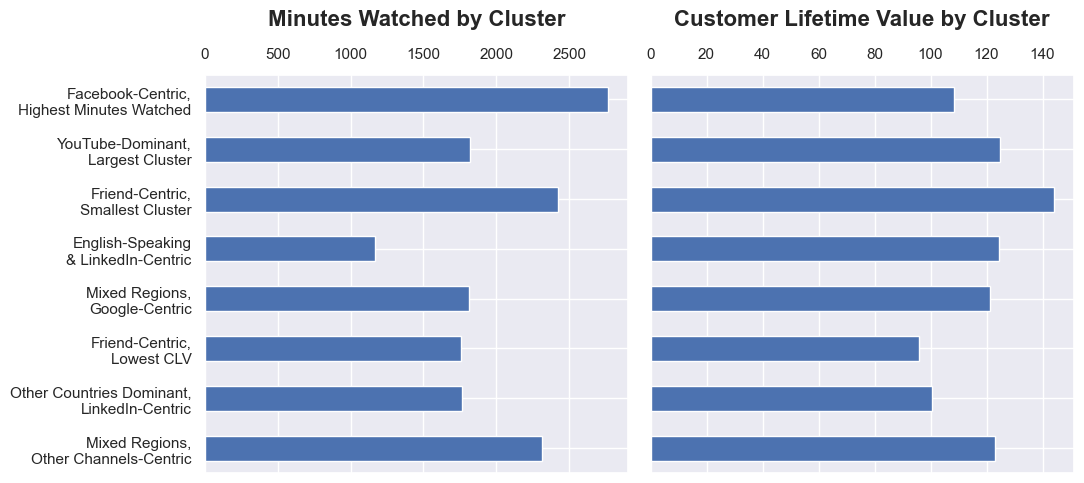

In [15]:
# Sort clusters, set index name, and rename clusters in customers_grouped for better interpretation
customers_grouped.sort_values('Cluster Number', ascending=False, inplace=True)
customers_grouped.index.name = 'Cluster Label'

customers_grouped = customers_grouped.rename({0:"Facebook-Centric,\nHighest Minutes Watched",
                                              1:"YouTube-Dominant,\nLargest Cluster",
                                              2:"Friend-Centric,\nSmallest Cluster",
                                              3:"English-Speaking\n& LinkedIn-Centric",
                                              4:"Mixed Regions,\nGoogle-Centric",
                                              5:"Friend-Centric,\nLowest CLV",
                                              6:"Other Countries Dominant,\nLinkedIn-Centric",
                                              7:"Mixed Regions,\nOther Channels-Centric"})


# Create side-by-side barh plots to visualize 'Minutes Watched' and 'CLV' by cluster
fig, axes = plt.subplots(1, 2, figsize=(11, 5), sharey=True)

customers_grouped['Minutes Watched'].plot(kind='barh', ax=axes[0], ylabel='')
customers_grouped['CLV'].plot(kind='barh', ax=axes[1], ylabel='')

axes[0].set_title('Minutes Watched by Cluster', fontweight='bold', fontsize=16, pad=16)
axes[1].set_title('Customer Lifetime Value by Cluster', fontweight='bold', fontsize=16, pad=16)

axes[0].tick_params(axis='x', labeltop=True, labelbottom=False)
axes[1].tick_params(axis='x', labeltop=True, labelbottom=False)

plt.tight_layout()
plt.show()

In [16]:
# Add new column for cluster labels in customers_kmean and display the first 3 rows
customers_kmean['Cluster Label'] = customers_kmean['Cluster Number'].map(
        {0:"Facebook-Centric, Highest Minutes Watched",
         1:"YouTube-Dominant, Largest Cluster",
         2:"Friend-Centric, Smallest Cluster",
         3:"English-Speaking & LinkedIn-Centric",
         4:"Mixed Regions, Google-Centric",
         5:"Friend-Centric, Lowest CLV",
         6:"Other Countries Dominant, LinkedIn-Centric",
         7:"Mixed Regions, Other Channels-Centric"})

customers_kmean.head(3)

,Minutes Watched,CLV,English-Speaking Countries,Western Europe,Other Countries,Google,Facebook,YouTube,LinkedIn,X,Instagram,Friend,Other,Cluster Number,Cluster Label
0,3197.0,205.42,False,False,True,False,False,False,True,False,False,False,False,6,"Other Countries Dominant, LinkedIn-Centric"
1,63.0,149.99,True,False,False,True,False,False,False,False,False,False,False,4,"Mixed Regions, Google-Centric"
2,605.0,119.00,False,False,True,False,True,False,False,False,False,False,False,0,"Facebook-Centric, Highest Minutes Watched"


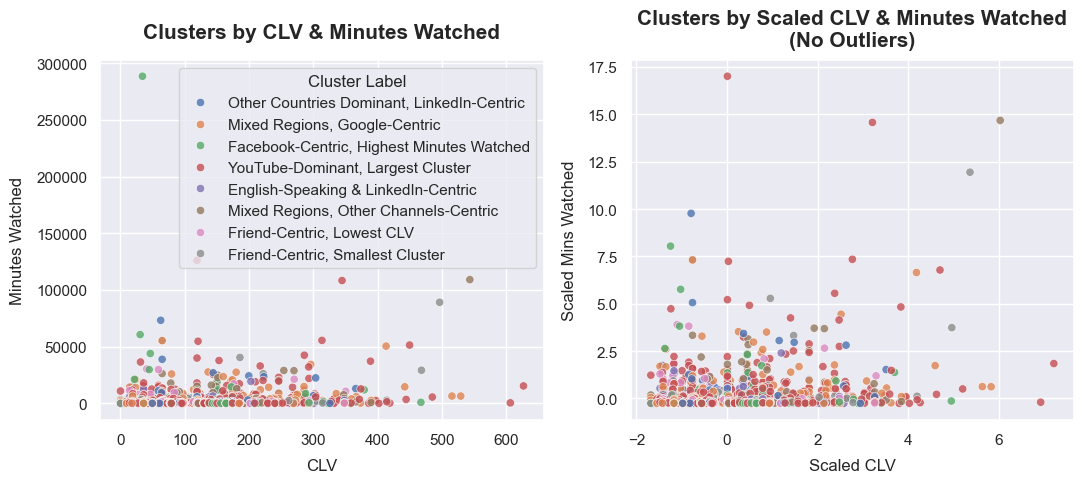

In [17]:
# Filter customers based on minutes watched and extract corresponding CLV, minutes watched, and cluster labels
clv_filtered = customers_scaled[:, 1][customers_scaled[:, 0] < 20]
minutes_filtered = customers_scaled[:, 0][customers_scaled[:, 0] < 20]
labels_filtered = customers_kmean.iloc[:, -1][customers_scaled[:, 0] < 20]


# Plot two scatter plots: one for original 'CLV' vs. 'Minutes Watched'
# and another for scaled 'CLV' vs. 'Minutes Watched' (without outliers)
fig, axes = plt.subplots(1, 2, figsize=(11, 5))

sns.scatterplot(x=customers_kmean['CLV'], y=customers_kmean['Minutes Watched'], 
                hue=customers_kmean['Cluster Label'], alpha=0.8, ax=axes[0])
axes[0].set_title('Clusters by CLV & Minutes Watched', fontweight='bold', fontsize=15, pad=16)
axes[0].set_ylabel('Minutes Watched', fontsize=12, labelpad=8)
axes[0].set_xlabel('CLV', fontsize=12, labelpad=8)

sns.scatterplot(x=clv_filtered, y=minutes_filtered, hue=labels_filtered, legend=False, alpha=0.8, ax=axes[1])
axes[1].set_title('Clusters by Scaled CLV & Minutes Watched\n(No Outliers)', fontweight='bold', fontsize=15, pad=10)
axes[1].set_ylabel('Scaled Mins Watched', fontsize=12, labelpad=8)
axes[1].set_xlabel('Scaled CLV', fontsize=12, labelpad=8)

plt.tight_layout()
plt.show()